## Импорт

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Я профи/semifinal"

Mounted at /content/drive
/content/drive/MyDrive/Я профи/semifinal


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
from time import strftime
import seaborn as sns

%matplotlib inline

In [4]:
data = pd.read_csv('Training_wells.csv')
unknown_data = pd.read_csv('Empty_part.csv')

print(len(data))
data.head()

138


Well    X    Y     NTG
0  201-907  201  907  0.2006
1  201-914  201  914  0.3624
2  201-924  201  924  0.4381
3  202-922  202  922  0.4289
4  202-925  202  925  0.4021

In [ ]:
# splitter_func = lambda x: list(map(int, x.split('-')))

In [ ]:
'''
data = pd.concat([data,
                  pd.DataFrame(data['Well'].apply(splitter_func).tolist(), columns=['Well_l', 'Well_r'])],
                  axis=1)
data.head()
'''

In [6]:
print('В данных есть пропуски? - %s' % str(data.isnull().any().any()))
print('Пропуски обнаружены в слудующих столбцах: ')
miss = data.isnull().any()[data.isnull().any() == True]
print(miss)
print('-'*40)
for i in miss.index:
  print('В столбце %s: %d пропусков, их доля %.2f%%' % (i, sum(data[i].isnull()), float(100 * sum(data[i].isnull())) / len(data)))

В данных есть пропуски? - False
Пропуски обнаружены в слудующих столбцах: 
Series([], dtype: bool)
----------------------------------------


## Статистики

In [7]:
data['X/Y'] = data.apply(lambda x: x['X'] / x['Y'], axis=1)
unknown_data['X/Y'] = unknown_data.apply(lambda x: x['X'] / x['Y'], axis=1)

X = np.array(data.drop(['NTG', 'Well'], axis=1))
X_unknown = np.array(unknown_data.drop(['Well'], axis=1))
y = np.array(data['NTG'])

In [9]:
correl = data.corr()
correl

X         Y       NTG       X/Y
X    1.000000 -0.026899 -0.055453  0.987966
Y   -0.026899  1.000000 -0.087215 -0.180926
NTG -0.055453 -0.087215  1.000000 -0.038681
X/Y  0.987966 -0.180926 -0.038681  1.000000

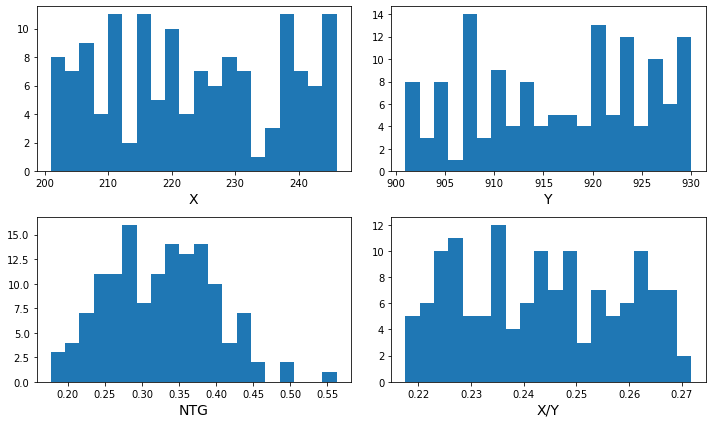

In [10]:
# Распределения признаков
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist(data[data.drop(['Well'], axis=1).columns[i]], bins=20)
    plt.xlabel(data.drop(['Well'], axis=1).columns[i], size=14)
plt.tight_layout()

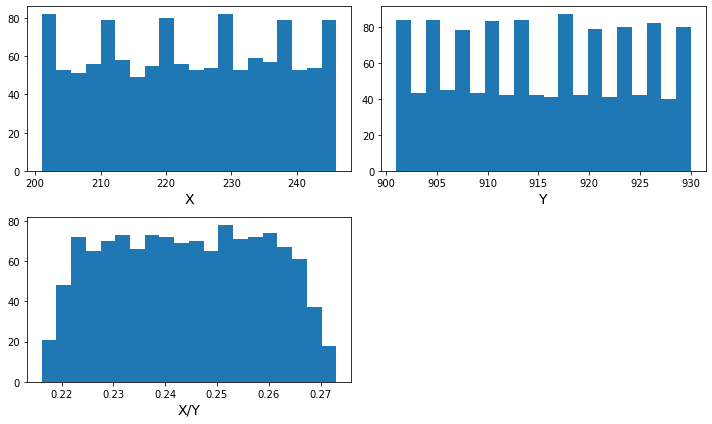

In [11]:
# Распределения признаков на неизвестных данных
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.subplot(2, 2, i+1)
    plt.hist(unknown_data[unknown_data.drop(['Well'], axis=1).columns[i]], bins=20)
    plt.xlabel(unknown_data.drop(['Well'], axis=1).columns[i], size=14)
plt.tight_layout()

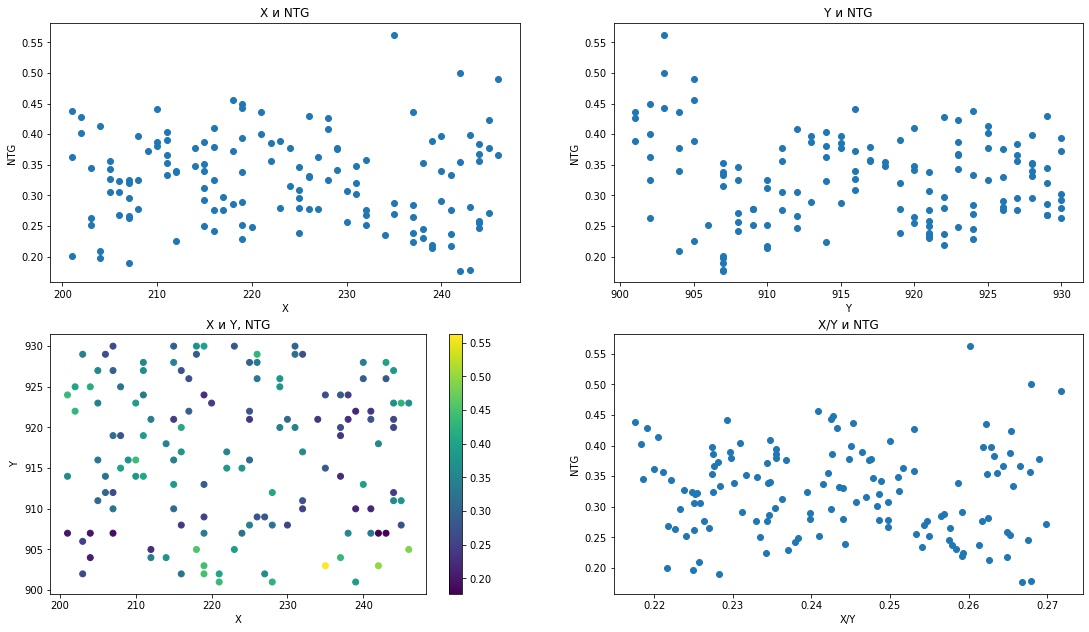

In [12]:
# Диаграммы рассеяния
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(18.5, 10.5)

ax[0, 0].scatter(data['X'], data['NTG'])
ax[0, 0].set_title('X и NTG')
ax[0, 0].set_xlabel('X')
ax[0, 0].set_ylabel('NTG')

ax[0, 1].scatter(data['Y'], data['NTG'])
ax[0, 1].set_title('Y и NTG')
ax[0, 1].set_xlabel('Y')
ax[0, 1].set_ylabel('NTG')

XY = ax[1, 0].scatter(data['X'], data['Y'], c=data['NTG'])
ax[1, 0].set_title('X и Y, NTG')
ax[1, 0].set_xlabel('X')
ax[1, 0].set_ylabel('Y')
fig.colorbar(XY, ax=ax[1, 0])

ax[1, 1].scatter(data['X/Y'], data['NTG'])
ax[1, 1].set_title('X/Y и NTG')
ax[1, 1].set_xlabel('X/Y')
ax[1, 1].set_ylabel('NTG')
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=240221)

X_train.shape

(131, 3)

# Модели

In [257]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
# from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
# from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import mean_squared_error as RMSE, r2_score
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer, PolynomialFeatures, FunctionTransformer, PowerTransformer, RobustScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.kernel_approximation import RBFSampler
from sklearn.compose import TransformedTargetRegressor

## Quantile transform

In [246]:
qt = QuantileTransformer(n_quantiles=138, output_distribution='normal', random_state=0)
qt_y = QuantileTransformer(n_quantiles=138, output_distribution='normal', random_state=0)
y_qt = qt_y.fit_transform(y.reshape(-1, 1))
X_qt = qt.fit_transform(X)
X_qt_unknown = qt.transform(X_unknown)
RMSE(qt_y.inverse_transform(y_qt), y, squared=False)

1.0566367053916907e-17

In [247]:
rs = RobustScaler(quantile_range=(2, 98))
X_qt_rs = rs.fit_transform(X_qt)

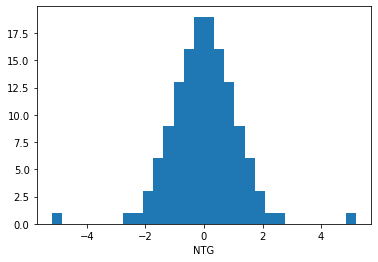

In [248]:
plt.hist(y_qt, bins=30)
plt.xlabel('NTG')
plt.show()

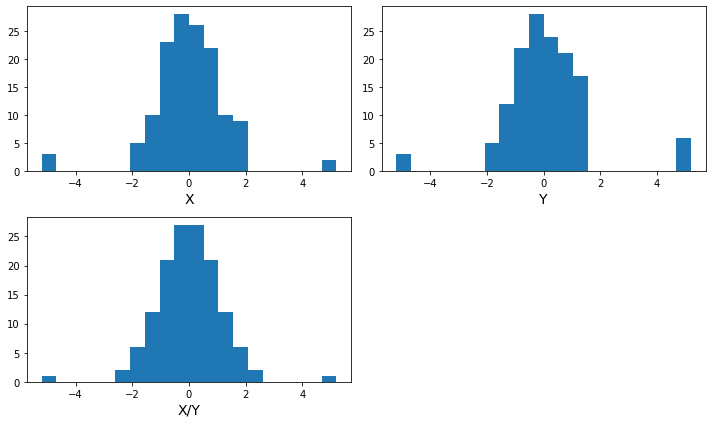

In [18]:
# Распределения признаков
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.subplot(2, 2, i+1)
    plt.hist(X_qt[:, i], bins=20)
    plt.xlabel(['X', 'Y', 'X/Y'][i], size=14)
plt.tight_layout()

In [19]:
np.corrcoef(X_qt, y, rowvar=False)

array([[ 1.        , -0.04597158,  0.9084298 ,  0.02511693],
       [-0.04597158,  1.        , -0.20416401, -0.13563032],
       [ 0.9084298 , -0.20416401,  1.        , -0.01520549],
       [ 0.02511693, -0.13563032, -0.01520549,  1.        ]])

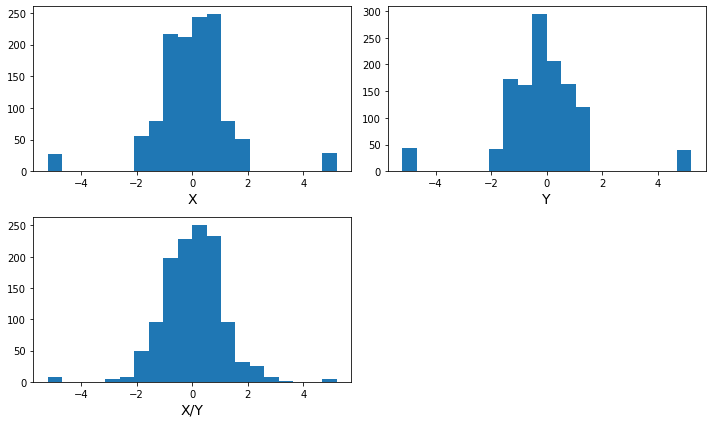

In [20]:
# Распределения признаков на неизвестных данных
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.subplot(2, 2, i+1)
    plt.hist(X_qt_unknown[:, i], bins=20)
    plt.xlabel(['X', 'Y', 'X/Y'][i], size=14)
plt.tight_layout()

In [21]:
np.corrcoef(X_qt_unknown, rowvar=False)

array([[ 1.        ,  0.0052627 ,  0.87567547],
       [ 0.0052627 ,  1.        , -0.18657088],
       [ 0.87567547, -0.18657088,  1.        ]])

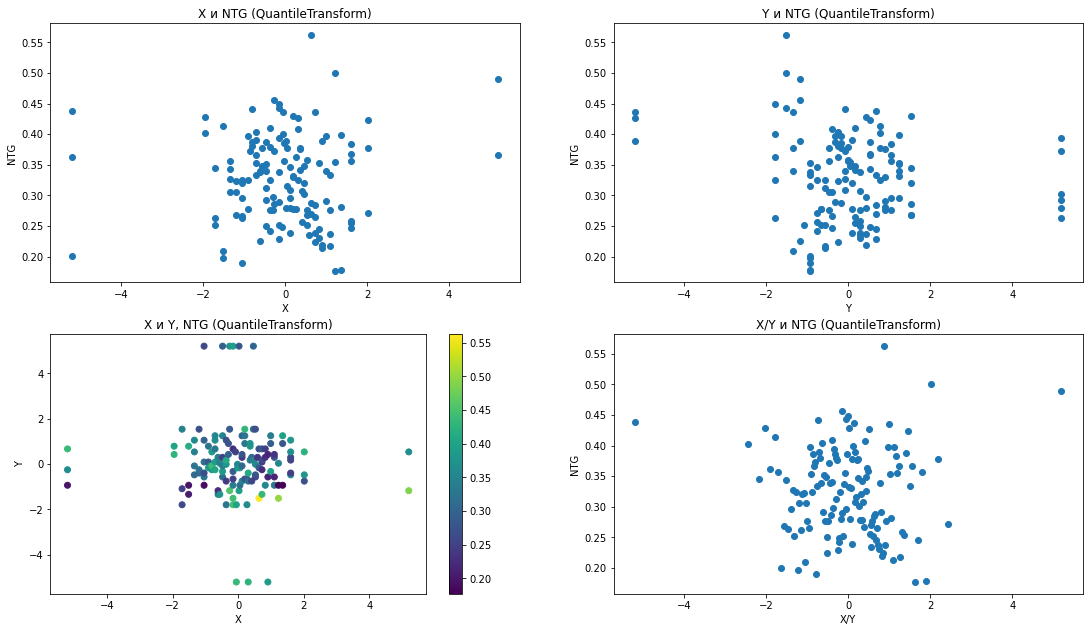

In [22]:
# Диаграммы рассеяния
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(18.5, 10.5)

ax[0, 0].scatter(X_qt[:, 0], y)
ax[0, 0].set_title('X и NTG (QuantileTransform)')
ax[0, 0].set_xlabel('X')
ax[0, 0].set_ylabel('NTG')

ax[0, 1].scatter(X_qt[:, 1], y)
ax[0, 1].set_title('Y и NTG (QuantileTransform)')
ax[0, 1].set_xlabel('Y')
ax[0, 1].set_ylabel('NTG')

XY = ax[1, 0].scatter(X_qt[:, 0], X_qt[:, 1], c=data['NTG'])
ax[1, 0].set_title('X и Y, NTG (QuantileTransform)')
ax[1, 0].set_xlabel('X')
ax[1, 0].set_ylabel('Y')
fig.colorbar(XY, ax=ax[1, 0])

ax[1, 1].scatter(X_qt[:, 2], data['NTG'])
ax[1, 1].set_title('X/Y и NTG (QuantileTransform)')
ax[1, 1].set_xlabel('X/Y')
ax[1, 1].set_ylabel('NTG')
plt.show()

## Mean and median

In [23]:
class MMEstimator(BaseEstimator):
    def __init__(self, strategy = 'mean'):
        self.strategy = strategy
        self.value = 0
    def fit(self, X, y):
        if self.strategy == 'mean':
            self.value = np.mean(y)
        elif self.strategy == 'median':
            self.value = np.median(y)
        else:
            raise ValueError()
        return self
    def predict(self, X):
        return np.array([self.value]*X.shape[0])

In [25]:
MM = MMEstimator(strategy='mean')
MM.fit(X_train, y_train)
pred = MM.predict(X_test)
print('test RMSE =', RMSE(y_test, pred, squared=False))
print('train RMSE =', RMSE(y_train, [y_train.mean()]*len(y_train), squared=False))

test RMSE = 0.06386495318214382
train RMSE = 0.07260081188185215


In [ ]:
cross_validate(MM, X[:, [0, 1]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.0599043795620438

In [26]:
MM = MMEstimator(strategy='median')
MM.fit(X_train, y_train)
pred = MM.predict(X_test)
print('test RMSE =', RMSE(y_test, pred, squared=False))
print('train RMSE =', RMSE(y_train, [np.median(y_train)]*len(y_train), squared=False))

test RMSE = 0.06355038496005691
train RMSE = 0.07260435027868037


In [27]:
cross_validate(MM, X[:, [0, 1]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.060370289855072444

## Linear regression

### NTG от Y

In [ ]:
LinReg = LinearRegression(normalize=True)
LinReg.fit(X_train[:, 1].reshape(-1, 1), y_train)
print('Coefficient of determination: %.2f'
      % r2_score(y_train, LinReg.predict(X_train[:, 1].reshape(-1, 1))))

Coefficient of determination: 0.01


RMSE = 0.06711177449171836


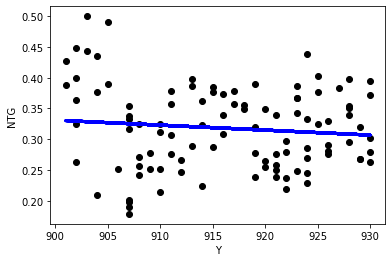

In [ ]:
# RMSE на трейне
pred = LinReg.predict(X_train[:, 1].reshape(-1, 1))
print('RMSE =', RMSE(y_train, pred, squared=False))

plt.scatter(X_train[:, 1], y_train,  color='black')
plt.plot(X_train[:, 1], pred, color='blue', linewidth=3)

plt.xlabel('Y')
plt.ylabel('NTG')

plt.show()

RMSE = 0.0859502144961215


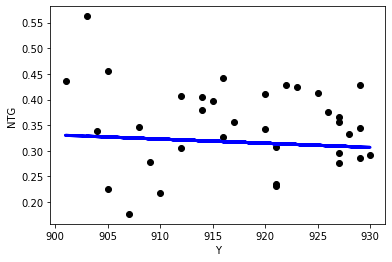

In [ ]:
# RMSE на тесте
pred = LinReg.predict(X_test[:, 1].reshape(-1, 1))
print('RMSE =', RMSE(y_test, pred, squared=False))

plt.scatter(X_test[:, 1], y_test,  color='black')
plt.plot(X_test[:, 1], pred, color='blue', linewidth=3)

plt.xlabel('Y')
plt.ylabel('NTG')

plt.show()

### NTG от X, Y

In [ ]:
LinReg = LinearRegression(normalize=True)
LinReg.fit(X_train[:, :2], y_train)
print('Coefficient of determination: %.2f'
      % r2_score(y_train, LinReg.predict(X_train[:, :2])))

Coefficient of determination: 0.01


RMSE = 0.08681870696723942


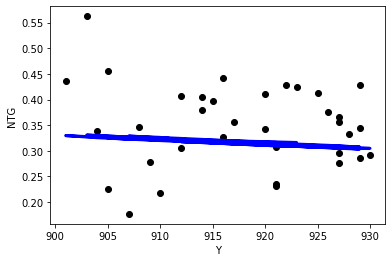

In [ ]:
pred = LinReg.predict(X_test[:, :2])
print('RMSE =', RMSE(y_test, pred, squared=False))

plt.scatter(X_test[:, 1], y_test,  color='black')
plt.plot(X_test[:, 1], pred, color='blue', linewidth=3)

plt.xlabel('Y')
plt.ylabel('NTG')

plt.show()

In [ ]:
cross_validate(LinReg, X[:, :2], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.060581730937318876

In [ ]:
# От всех 3-х фичей
cross_validate(LinReg, X, y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.05806467787180927

In [ ]:
cross_validate(make_pipeline(
    QuantileTransformer(n_quantiles=137, output_distribution='normal', random_state=0),
    HuberRegressor(epsilon=10, max_iter=1000, alpha=100)
), X[:, [0, 1, 2]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.0595639905003341

### One-hot features

In [ ]:
OneHot = OneHotEncoder()
# OneHot.fit(np.array(data['X']).reshape(-1, 1))
OneHot.fit(data[['X', 'Y']])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [ ]:
X_onehot = np.concatenate([X,
                           # OneHot.transform(np.array(data['X']).reshape(-1, 1)).toarray()],
                           OneHot.transform(data[['X', 'Y']]).toarray()],
                           axis=1)
X_onehot = X_onehot[:, 2:]
X_onehot.shape

(138, 74)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.25, random_state=240221)
X_train.shape

(103, 74)

In [ ]:
LinReg = LinearRegression(normalize=True)
LinReg.fit(X_train, y_train)
print('Coefficient of determination: %.2f'
      % r2_score(y_train, LinReg.predict(X_train)))

Coefficient of determination: 0.75


RMSE = 0.03343997133724168


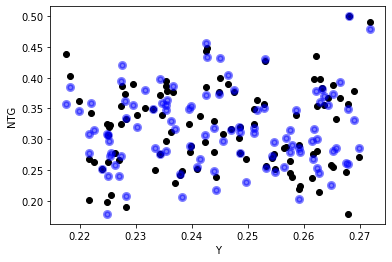

In [ ]:
pred = np.clip(LinReg.predict(X_train), np.min(y_train), np.max(y_train))
print('RMSE =', RMSE(y_train, pred, squared=False))

plt.scatter(X_train[:, 0], y_train,  color='black')
plt.scatter(X_train[:, 0], pred, color='blue', linewidth=3, alpha=0.5)

plt.xlabel('Y')
plt.ylabel('NTG')

plt.show()

RMSE = 0.10567037963490389


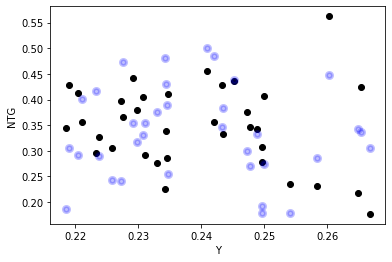

In [ ]:
pred = np.clip(LinReg.predict(X_test), np.min(y_train), np.max(y_train))
print('RMSE =', RMSE(y_test, pred, squared=False))

plt.scatter(X_test[:, 0], y_test,  color='black')
plt.scatter(X_test[:, 0], pred, color='blue', linewidth=3, alpha=0.25)

plt.xlabel('Y')
plt.ylabel('NTG')

plt.show()

In [ ]:
print(cross_validate(LinReg, X_onehot, y, cv=10, scoring='neg_root_mean_squared_error')['test_score'].mean())
LinReg.coef_[:10] # Коэффициенты слишком большие, нужна регуляризация

-16654625690584.012


array([8.49283358e+01, 2.03788179e+11, 2.03788179e+11, 2.03788179e+11,
       2.03788179e+11, 2.03788179e+11, 2.03788179e+11, 2.03788179e+11,
       2.03788179e+11, 2.03788179e+11])

In [ ]:
RDG = Ridge(alpha=4)
RDG.fit(X_train, y_train)
print('Coefficient of determination: %.2f'
      % r2_score(y_train, RDG.predict(X_train)))

Coefficient of determination: 0.48


RMSE = 0.07944229109175403


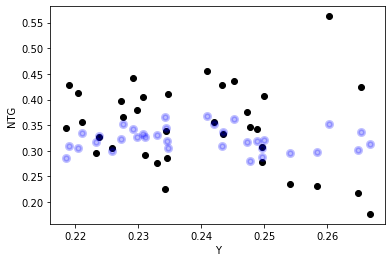

In [ ]:
pred = RDG.predict(X_test)
print('RMSE =', RMSE(y_test, pred, squared=False))

plt.scatter(X_test[:, 0], y_test,  color='black')
plt.scatter(X_test[:, 0], pred, color='blue', linewidth=3, alpha=0.25)

plt.xlabel('Y')
plt.ylabel('NTG')

plt.show()

In [ ]:
cv_scores = []
for i in np.arange(2, 5.05, 0.05):
    cv_scores.append(cross_validate(Ridge(alpha=i), X_onehot, y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean())

In [ ]:
np.max(cv_scores), np.arange(2, 5.05, 0.05)[np.argmax(cv_scores)] # alpha = 4 оптимальный параметр

(-0.0568956322364325, 3.999999999999993)

Качество хорошее, но можно еще лучше

## MLP

In [169]:
MLPPipe = Pipeline(
    [('qt', QuantileTransformer(n_quantiles=100, output_distribution='normal', random_state=280221)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(256, 16), max_iter=5000, solver='lbfgs', activation='relu', alpha=0.01, random_state=0))]
)
MLPPipe.fit(X_train[:, [1, 2]], y_train)

Pipeline(memory=None,
         steps=[('qt',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=100,
                                     output_distribution='normal',
                                     random_state=280221, subsample=100000)),
                ('mlp',
                 MLPRegressor(activation='relu', alpha=0.01, batch_size='auto',
                              beta_1=0.9, beta_2=0.999, early_stopping=False,
                              epsilon=1e-08, hidden_layer_sizes=(256, 16),
                              learning_rate='constant',
                              learning_rate_init=0.001, max_fun=15000,
                              max_iter=5000, momentum=0.9, n_iter_no_change=10,
                              nesterovs_momentum=True, power_t=0.5,
                              random_state=0, shuffle=True, solver='lbfgs',
                              tol=0.0001, validation_fraction=0.1,
    

In [262]:
class MyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_quantiles=100, output_distribution='normal', random_state=280221, value=6):
        self.qt = QuantileTransformer(n_quantiles=100, output_distribution='normal', random_state=280221)
        self.value = value
    def fit(self, X, y = None):
        self.qt.fit(X)
        return self
    def transform(self, X, y = None):
        return self.qt.transform(X) / self.value
    def inverse_transform(self, X, y = None):
        return self.qt.inverse_transform(X * self.value)

In [ ]:
%%time
MLPregr = TransformedTargetRegressor(
    regressor=Pipeline(
        [('qt', QuantileTransformer(n_quantiles=100, output_distribution='normal', random_state=280221)),
        ('mlp', MLPRegressor(hidden_layer_sizes=(256, 16), max_iter=5000, solver='lbfgs', activation='tanh', alpha=0.01, random_state=0))]
    ),
    transformer=MyTransformer()
)
# MLPregr.fit(X_train[:, [1, 2]], y_train)
print(cross_validate(MLPregr, X[:, [1, 2]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean())

RMSE = 0.021543196733283698


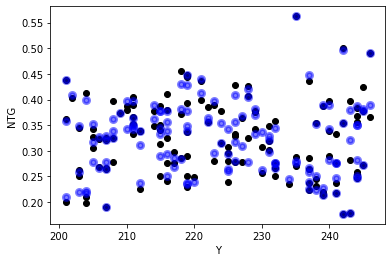

In [269]:
pred = MLPregr.predict(X_train[:, [1, 2]])
print('RMSE =', RMSE(y_train, pred, squared=False))

plt.scatter(X_train[:, 0], y_train,  color='black')
plt.scatter(X_train[:, 0], pred, color='blue', linewidth=3, alpha=0.5)

plt.xlabel('Y')
plt.ylabel('NTG')

plt.show()

RMSE = 0.05158117812282273


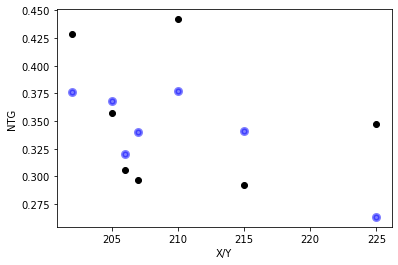

In [270]:
pred = MLPregr.predict(X_test[:, [1, 2]])
print('RMSE =', RMSE(y_test, pred, squared=False))

plt.scatter(X_test[:, 0], y_test,  color='black')
plt.scatter(X_test[:, 0], pred, color='blue', linewidth=3, alpha=0.5)

plt.xlabel('X/Y')
plt.ylabel('NTG')

plt.show()

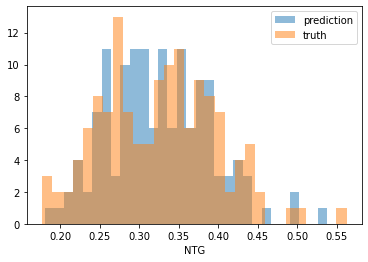

In [175]:
plt.hist(MLPPipe.predict(X[:, [1, 2]]), alpha=0.5, bins=30)
plt.hist(y, alpha=0.5, bins=30)
plt.legend(['prediction', 'truth'])
plt.xlabel('NTG')
plt.show()

In [ ]:
%%time
gs = GridSearchCV(
    MLPPipe,
    {
        'mlp__hidden_layer_sizes': [
                               (256, 16)
        ],
        'mlp__alpha': [0.001, 0.005, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15]
    },
    cv=5
)
gs.fit(X[:, [1, 2]], y)
print(gs.best_params_)

{'mlp__alpha': 0.05, 'mlp__hidden_layer_sizes': (256, 16)}
CPU times: user 1min 2s, sys: 45.2 s, total: 1min 48s
Wall time: 54.8 s


In [ ]:
# 256, 16
cross_validate(MLPPipe, X[:, [1, 2]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.04857159125577241

In [ ]:
%%time
# 256, 16, alpha = 0.05
print(cross_validate(MLPPipe, X[:, [1, 2]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean())

-0.05119229333163927
CPU times: user 2min 52s, sys: 2min 11s, total: 5min 4s
Wall time: 2min 34s


In [ ]:
# 128, 64
cross_validate(MLPPipe, X[:, [1, 2]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.049797942321062695

In [ ]:
# 32 16 8 4
cross_validate(MLPPipe, X[:, [1, 2]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.05041117671241926

In [132]:
MLP_oh = Pipeline(
    [('oh', OneHotEncoder(categories=[np.unique(X[:, [0]]),
                                      np.unique(X[:, [1]])
                                      ])),
    ('mlp', MLPRegressor(hidden_layer_sizes=(512), max_iter=5000, solver='lbfgs', activation='logistic', alpha=0.1, random_state=0))
    # ('rdg', RidgeCV(alphas=(0.001, 0.01, 0.1, 1, 10), cv=10))
    ]
)
MLP_oh.fit(X_train[:, [0, 1]], y_train)

Pipeline(memory=None,
         steps=[('oh',
                 OneHotEncoder(categories=[array([201., 202., 203., 204., 205., 206., 207., 208., 209., 210., 211.,
       212., 214., 215., 216., 217., 218., 219., 220., 221., 222., 223.,
       224., 225., 226., 227., 228., 229., 230., 231., 232., 234., 235.,
       237., 238., 239., 240., 241., 242., 243., 244., 245., 246.]),
                                           array([901., 902., 903., 904., 905., 906., 907., 908., 909., 910., 911.,
       912....
                              batch_size='auto', beta_1=0.9, beta_2=0.999,
                              early_stopping=False, epsilon=1e-08,
                              hidden_layer_sizes=512, learning_rate='constant',
                              learning_rate_init=0.001, max_fun=15000,
                              max_iter=5000, momentum=0.9, n_iter_no_change=10,
                              nesterovs_momentum=True, power_t=0.5,
                              random_state=0, shuffl

RMSE = 0.04558254023985342


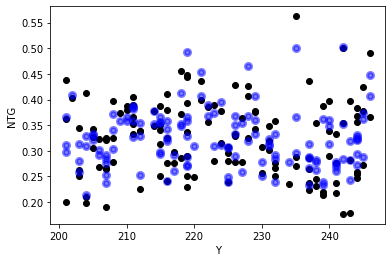

In [125]:
pred = MLP_oh.predict(X_train[:, [0, 1]])
print('RMSE =', RMSE(y_train, pred, squared=False))

plt.scatter(X_train[:, 0], y_train,  color='black')
plt.scatter(X_train[:, 0], pred, color='blue', linewidth=3, alpha=0.5)

plt.xlabel('Y')
plt.ylabel('NTG')

plt.show()

RMSE = 0.07679415496257712


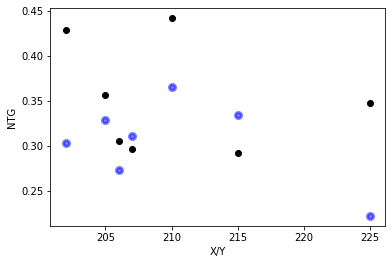

In [126]:
pred = MLP_oh.predict(X_test[:, [0, 1]])
print('RMSE =', RMSE(y_test, pred, squared=False))

plt.scatter(X_test[:, 0], y_test,  color='black')
plt.scatter(X_test[:, 0], pred, color='blue', linewidth=3, alpha=0.5)

plt.xlabel('X/Y')
plt.ylabel('NTG')

plt.show()

In [130]:
%%time
# На onehot всех признаках
print(cross_validate(MLP_oh, X[:, [0, 1]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean())

-0.060019471804631436
CPU times: user 1min 2s, sys: 1min 18s, total: 2min 21s
Wall time: 1min 11s


In [ ]:
# На onehot всех признаках
cross_validate(MLP, X_onehot, y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.05991020994243116

In [ ]:
# На onehot без первого
cross_validate(MLP, X_onehot[:, 1:], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.05990001272555537

In [ ]:
# На всех признаках
cross_validate(MLP, X, y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.05990389057699855

In [ ]:
# На исходных признаках
cross_validate(MLP, X[:, [0, 1]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.05990178815524692

Прироста в качестве у нейронной сети не наблюдается

In [ ]:
MLPPipe_rbf = Pipeline(
    [('qt', QuantileTransformer(n_quantiles=100, output_distribution='normal', random_state=280221)),
     ('rs', RobustScaler()),
     ('rbf', RBFSampler(gamma=2.5, n_components=100, random_state=1)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(128, 16), max_iter=5000, solver='lbfgs', activation='relu', alpha=0.01, random_state=0))]
)
MLPPipe_rbf.fit(X_train[:, [1, 2]], y_train)

Pipeline(memory=None,
         steps=[('qt',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=100,
                                     output_distribution='normal',
                                     random_state=280221, subsample=100000)),
                ('rbf',
                 RBFSampler(gamma=2.5, n_components=100, random_state=1)),
                ('mlp',
                 MLPRegressor(activation='relu', alpha=0.01, batch_size='auto',
                              beta_1=0.9, beta_2=0.999, early_stopping=False,
                              epsilon=1e-08, hidden_layer_sizes=(128, 16),
                              learning_rate='constant',
                              learning_rate_init=0.001, max_fun=15000,
                              max_iter=5000, momentum=0.9, n_iter_no_change=10,
                              nesterovs_momentum=True, power_t=0.5,
                              random_state=0, sh

RMSE = 0.01096236325865492


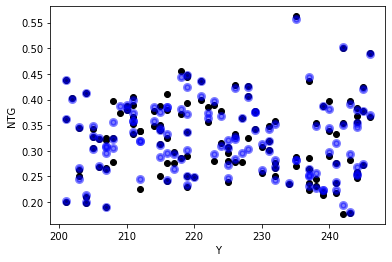

In [ ]:
pred = MLPPipe_rbf.predict(X_train[:, [1, 2]])
print('RMSE =', RMSE(y_train, pred, squared=False))

plt.scatter(X_train[:, 0], y_train,  color='black')
plt.scatter(X_train[:, 0], pred, color='blue', linewidth=3, alpha=0.5)

plt.xlabel('Y')
plt.ylabel('NTG')

plt.show()

RMSE = 0.04843796304534272


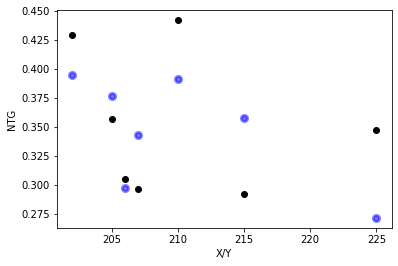

In [ ]:
pred = MLPPipe_rbf.predict(X_test[:, [1, 2]])
print('RMSE =', RMSE(y_test, pred, squared=False))

plt.scatter(X_test[:, 0], y_test,  color='black')
plt.scatter(X_test[:, 0], pred, color='blue', linewidth=3, alpha=0.5)

plt.xlabel('X/Y')
plt.ylabel('NTG')

plt.show()

In [ ]:
cross_validate(MLPPipe_rbf, X[:, [1, 2]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.05390196106482392

In [ ]:
%%time
print(
    cross_validate(MLPPipe_rbf, X[:, [1, 2]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()
)

-0.056269848639025996
CPU times: user 6min 35s, sys: 7min 48s, total: 14min 24s
Wall time: 7min 21s


In [ ]:
MLPPipe_rs_rbf = Pipeline(
    [('qt', QuantileTransformer(n_quantiles=100, output_distribution='normal', random_state=280221)),
     # ('rs', RobustScaler(quantile_range=(15, 85))),
     ('rbf', RBFSampler(gamma=2.5, n_components=100, random_state=1)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(128, 8), max_iter=5000, solver='lbfgs', activation='relu', alpha=0.01, random_state=0))]
)
MLPPipe_rs_rbf.fit(X_train[:, [1, 2]], y_train)

Pipeline(memory=None,
         steps=[('qt',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=100,
                                     output_distribution='normal',
                                     random_state=280221, subsample=100000)),
                ('rbf',
                 RBFSampler(gamma=2.5, n_components=100, random_state=1)),
                ('mlp',
                 MLPRegressor(activation='relu', alpha=0.01, batch_size='auto',
                              beta_1=0.9, beta_2=0.999, early_stopping=False,
                              epsilon=1e-08, hidden_layer_sizes=(128, 8),
                              learning_rate='constant',
                              learning_rate_init=0.001, max_fun=15000,
                              max_iter=5000, momentum=0.9, n_iter_no_change=10,
                              nesterovs_momentum=True, power_t=0.5,
                              random_state=0, shu

RMSE = 0.011215779761994293


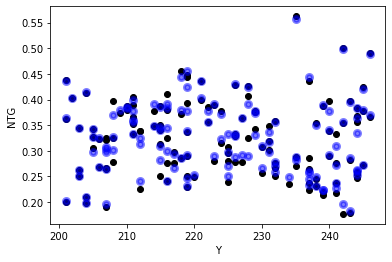

In [ ]:
pred = MLPPipe_rs_rbf.predict(X_train[:, [1, 2]])
print('RMSE =', RMSE(y_train, pred, squared=False))

plt.scatter(X_train[:, 0], y_train,  color='black')
plt.scatter(X_train[:, 0], pred, color='blue', linewidth=3, alpha=0.5)

plt.xlabel('Y')
plt.ylabel('NTG')

plt.show()

RMSE = 0.04576982402022853


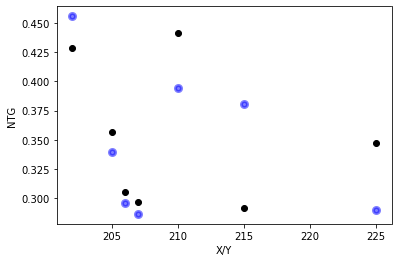

In [ ]:
pred = MLPPipe_rs_rbf.predict(X_test[:, [1, 2]])
print('RMSE =', RMSE(y_test, pred, squared=False))

plt.scatter(X_test[:, 0], y_test,  color='black')
plt.scatter(X_test[:, 0], pred, color='blue', linewidth=3, alpha=0.5)

plt.xlabel('X/Y')
plt.ylabel('NTG')

plt.show()

In [ ]:
%%time
# 128
print(
    cross_validate(MLPPipe_rs_rbf, X[:, [1, 2]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()
)

-0.05204876005207858
CPU times: user 5min 20s, sys: 6min 29s, total: 11min 49s
Wall time: 6min


In [ ]:
%%time
# 256 16
print(
    cross_validate(MLPPipe_rs_rbf, X[:, [1, 2]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()
)

-0.05244240109977469
CPU times: user 8min 12s, sys: 5min 49s, total: 14min 2s
Wall time: 7min 7s


## GB

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=240221)

In [133]:
GBR = GradientBoostingRegressor(loss='ls',
                                n_estimators=800,
                                max_depth=2,
                                min_samples_leaf=1,
                                random_state=240221)
GBR.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=800,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=240221, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

RMSE = 0.0056381697059105715


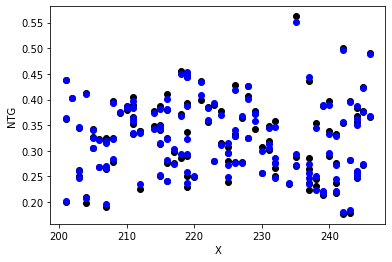

In [138]:
# RMSE на трейне
pred = GBR.predict(X_train)
print('RMSE =', RMSE(y_train, pred, squared=False))

plt.scatter(X_train[:, 0], y_train,  color='black')
plt.scatter(X_train[:, 0], pred, color='blue', linewidth=1)

plt.xlabel('X')
plt.ylabel('NTG')

plt.show()

RMSE = 0.06648053489833665


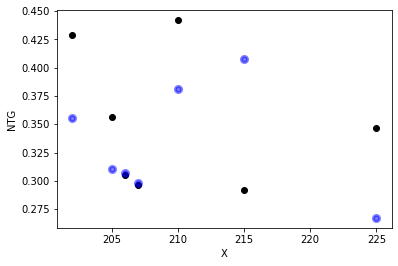

In [139]:
# RMSE на тесте
pred = GBR.predict(X_test)
print('RMSE =', RMSE(y_test, pred, squared=False))

plt.scatter(X_test[:, 0], y_test,  color='black')
plt.scatter(X_test[:, 0], pred, color='blue', linewidth=3, alpha=0.5)

plt.xlabel('X')
plt.ylabel('NTG')

plt.show()

In [ ]:
cross_validate(GBR, X[:, 1:], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.04780895594832995

In [ ]:
cross_validate(GBR, X[:, [0, 1]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.05388467131271267

In [ ]:
cv_scores = []
for i in range(5, 100):
    GBR = GradientBoostingRegressor(loss='ls',
                                    n_estimators=i,
                                    max_depth=2,
                                    min_samples_leaf=1,
                                    random_state=240221)
    cv_scores.append(cross_validate(GBR, X, y, cv=10, scoring='neg_root_mean_squared_error')['test_score'].mean())

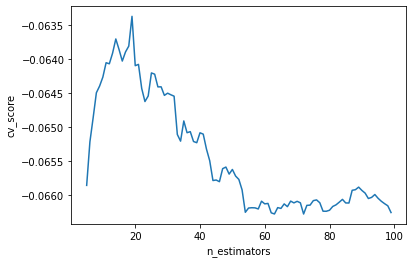

In [ ]:
plt.plot(list(range(5, 100)), cv_scores)
plt.xlabel('n_estimators')
plt.ylabel('cv_score')
plt.show()

## Random Forest

In [ ]:
RF = RandomForestRegressor(n_estimators=800,
                           criterion='mse',
                           max_depth=None,
                           min_samples_leaf=1,
                           random_state=240221)
RF.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=800, n_jobs=None, oob_score=False,
                      random_state=240221, verbose=0, warm_start=False)

RMSE = 0.019894363675563118


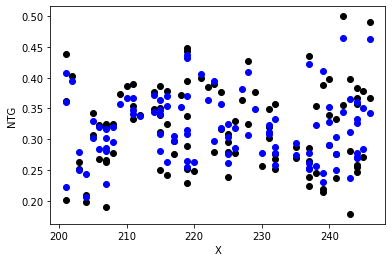

In [ ]:
# RMSE на трейне
pred = RF.predict(X_train)
print('RMSE =', RMSE(y_train, pred, squared=False))

plt.scatter(X_train[:, 0], y_train,  color='black')
plt.scatter(X_train[:, 0], pred, color='blue', linewidth=1)

plt.xlabel('X')
plt.ylabel('NTG')

plt.show()

RMSE = 0.06512222408449884


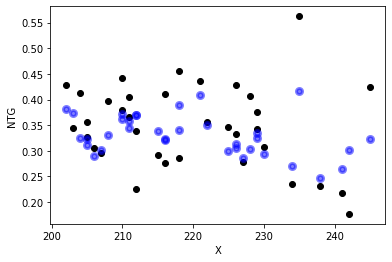

In [ ]:
# RMSE на тесте
pred = RF.predict(X_test)
print('RMSE =', RMSE(y_test, pred, squared=False))

plt.scatter(X_test[:, 0], y_test,  color='black')
plt.scatter(X_test[:, 0], pred, color='blue', linewidth=3, alpha=0.5)

plt.xlabel('X')
plt.ylabel('NTG')

plt.show()

In [ ]:
cross_validate(RF, X, y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

In [ ]:
cv_scores = []
for i in range(5, 100):
    RF = RandomForestRegressor(n_estimators=i,
                              criterion='mse',
                              max_depth=5,
                              min_samples_leaf=2,
                              random_state=240221)
    cv_scores.append(cross_validate(RF, X, y, cv=10, scoring='neg_root_mean_squared_error')['test_score'].mean())

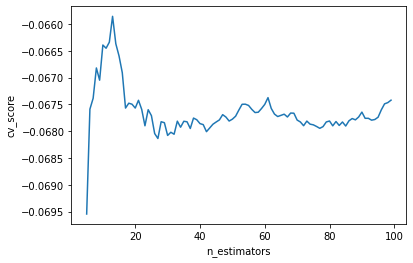

In [ ]:
plt.plot(list(range(5, 100)), cv_scores)
plt.xlabel('n_estimators')
plt.ylabel('cv_score')
plt.show()

## Cat Boost 

In [29]:
!pip install catboost
from catboost import CatBoostRegressor, Pool, cv

     |████████████████████████████████| 65.7MB 65kB/s 


In [184]:
CBR = CatBoostRegressor(iterations=1500, 
                        depth=3, 
                        # learning_rate=0.1,
                        l2_leaf_reg=1, 
                        loss_function='RMSE',
                        verbose=False)

train_dataset = Pool(data=X_train[:, [1, 2]],
                     label=y_train,
                     cat_features=None)

eval_dataset = Pool(data=X_test[:, [1, 2]],
                    label=y_test,
                    cat_features=None)

CBR.fit(train_dataset,
        use_best_model=False,
        eval_set=eval_dataset)

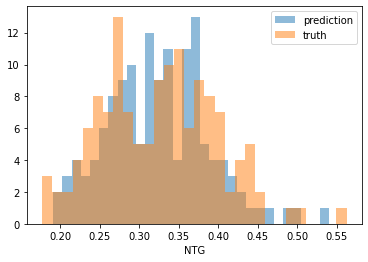

In [185]:
plt.hist(CBR.predict(X[:, [1, 2]]), alpha=0.5, bins=30)
plt.hist(y, alpha=0.5, bins=30)
plt.legend(['prediction', 'truth'])
plt.xlabel('NTG')
plt.show()

In [179]:
class GBFeatureRegressor(BaseEstimator):
    def __init__(self, GBRegressor=None, final_estimator=None, ratio=0.9):
        if GBRegressor:
            self.GBR = GBRegressor
        else:
            self.GBR = CatBoostRegressor(iterations=1500, 
                                        depth=3, 
                                        # learning_rate=0.1, 
                                        l2_leaf_reg=1, 
                                        loss_function='RMSE',
                                        verbose=False)
        if final_estimator:
            self.final_estimator = final_estimator
        else:
            self.final_estimator = LinearRegression()
    def fit(self, X, y):
        return NotImplementedError()
    def predict(self, X):
        return NotImplementedError()

In [ ]:
cross_validate(CBR, X, y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.0459635380734071

In [ ]:
cross_validate(CBR, X[:, [0, 1]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.04841143963052904

In [ ]:
# 1000 iter
cross_validate(CBR, X[:, [1, 2]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.043788579769231666

In [ ]:
# 1500 iter
CBR = CatBoostRegressor(iterations=1500, 
                        depth=3, 
                        # learning_rate=0.1,
                        l2_leaf_reg=1, 
                        loss_function='RMSE',
                        verbose=False)
cross_validate(CBR, X[:, [1, 2]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.043759592953511534

In [ ]:
# 1500 iter
CBR = CatBoostRegressor(iterations=1500, 
                        depth=3, 
                        # learning_rate=0.1,
                        l2_leaf_reg=1, 
                        loss_function='RMSE',
                        verbose=False)
cross_validate(make_pipeline(
    QuantileTransformer(n_quantiles=137, output_distribution='normal', random_state=280221),
    CBR
), X[:, [1, 2]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.043813532548485225

In [ ]:
cross_validate(CatBoostRegressor(iterations=779, 
                                depth=2, 
                                # learning_rate=0.1, 
                                loss_function='RMSE',
                                verbose=False), X[:, [1, 2]], y,
                cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.04588027800567501

In [ ]:
cross_validate(CBR, X[:, [0, 2]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.05853858186490112

In [191]:
%%time
regr = TransformedTargetRegressor(
    regressor=CatBoostRegressor(iterations=1500, 
                        depth=3, 
                        # learning_rate=0.1,
                        l2_leaf_reg=1, 
                        loss_function='RMSE',
                        verbose=False),
    transformer=QuantileTransformer(n_quantiles=137, output_distribution='normal', random_state=1)
)
print(cross_validate(regr, X[:, [1, 2]], y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean())

-0.04652813735432181
CPU times: user 1min 11s, sys: 34.8 s, total: 1min 45s
Wall time: 2min 16s


RMSE = 0.015377096983889898


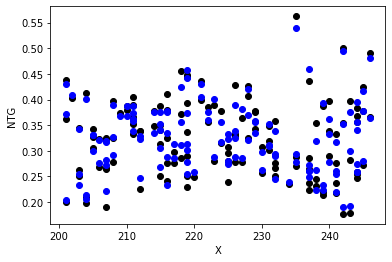

In [187]:
# RMSE на трейне
pred = CBR.predict(X_train[:, [1, 2]])
print('RMSE =', RMSE(y_train, pred, squared=False))

plt.scatter(X_train[:, 0], y_train,  color='black')
plt.scatter(X_train[:, 0], pred, color='blue', linewidth=1)

plt.xlabel('X')
plt.ylabel('NTG')

plt.show()

RMSE = 0.04442948310505841


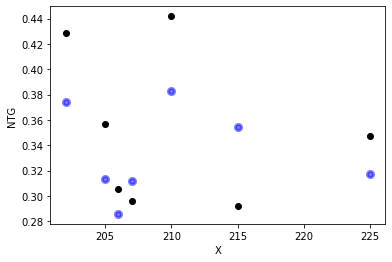

In [188]:
# RMSE на тесте
pred = CBR.predict(X_test[:, [1, 2]])
print('RMSE =', RMSE(y_test, pred, squared=False))

plt.scatter(X_test[:, 0], y_test,  color='black')
plt.scatter(X_test[:, 0], pred, color='blue', linewidth=3, alpha=0.5)

plt.xlabel('X')
plt.ylabel('NTG')

plt.show()

In [ ]:
# Кросс-валидация

cv_data = X

labels = y

cv_dataset = Pool(data=cv_data,
                  label=labels,
                  cat_features=None)

params = {"iterations": 1000,
          "depth": 2,
          "loss_function": "RMSE",
          "verbose": True}

scores = cv(cv_dataset,
            params,
            fold_count=100, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3246380	test: 0.3168404	best: 0.3168404 (0)	total: 3.09s	remaining: 51m 30s
1:	learn: 0.3159606	test: 0.3079931	best: 0.3079931 (1)	total: 6.26s	remaining: 52m 5s
2:	learn: 0.3076672	test: 0.2995427	best: 0.2995427 (2)	total: 9.35s	remaining: 51m 48s
3:	learn: 0.2996043	test: 0.2912972	best: 0.2912972 (3)	total: 12.5s	remaining: 51m 51s
4:	learn: 0.2918033	test: 0.2833232	best: 0.2833232 (4)	total: 15.6s	remaining: 51m 49s
5:	learn: 0.2841380	test: 0.2755256	best: 0.2755256 (5)	total: 18.7s	remaining: 51m 42s
6:	learn: 0.2766405	test: 0.2678314	best: 0.2678314 (6)	total: 21.8s	remaining: 51m 29s
7:	learn: 0.2693232	test: 0.2603485	best: 0.2603485 (7)	total: 24.8s	remaining: 51m 15s
8:	learn: 0.2622783	test: 0.2531039	best: 0.2531039 (8)	total: 27.8s	remaining: 51m 4s
9:	learn: 0.2555467	test: 0.2461936	best: 0.2461936 (9)	total: 30.8s	remaining: 50m 47s
10:	learn: 0.2488494	test: 0.2392873	best: 0.2392873 (10)	total: 33.7s	remaining: 50m 29s
11:	learn: 0.2425057	test: 0.232

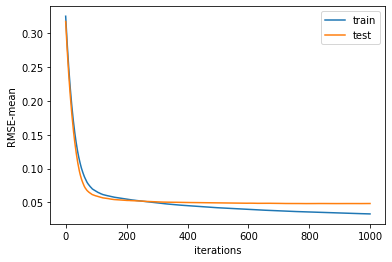

iterations         779.000000
test-RMSE-mean       0.048371
test-RMSE-std        0.031807
train-RMSE-mean      0.036276
train-RMSE-std       0.000281
Name: 779, dtype: float64

In [ ]:
plt.plot(scores['iterations'], scores['train-RMSE-mean'])
plt.plot(scores['iterations'], scores['test-RMSE-mean'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE-mean')
plt.xlabel('iterations')
plt.show()
scores.iloc[np.argmin(scores['test-RMSE-mean'])]

In [ ]:
scores.iloc[np.argmin(scores['test-RMSE-std'])]

iterations         249.000000
test-RMSE-mean       0.052061
test-RMSE-std        0.031287
train-RMSE-mean      0.051958
train-RMSE-std       0.000365
Name: 249, dtype: float64

__РЕШЕНИЕ 1__

In [ ]:
CBR = CatBoostRegressor(iterations=779, 
                        depth=2, 
                        # learning_rate=0.1, 
                        loss_function='RMSE',
                        verbose=False)
CBR.fit(X[:, [1, 2]], y)
pred = CBR.predict(X_unknown[:, [1, 2]])
unknown_data['NTG'] = pred
pred

array([0.23910302, 0.23948169, 0.2775347 , ..., 0.36496862, 0.36256292,
       0.37166132])

In [ ]:
# Сохранение 27 фев 2021, 02:35:21
unknown_data.drop('X/Y', axis=1).to_csv(strftime("%Y-%m-%d %H:%M:%S") + " prediction.csv", index=False)
# np.savetxt("prediction.csv", ... ,delimiter=",", fmt='%s')
strftime("%Y-%m-%d %H:%M:%S")

'2021-02-26 23:34:28'

__РЕШЕНИЕ 1__

### Остатки

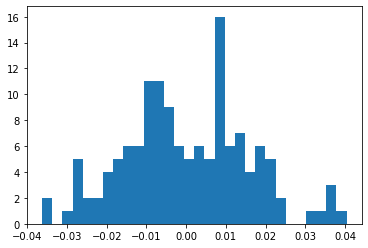

0         1         2         3
0  1.000000 -0.026899  0.987966 -0.008741
1 -0.026899  1.000000 -0.180926 -0.008426
2  0.987966 -0.180926  1.000000 -0.007315
3 -0.008741 -0.008426 -0.007315  1.000000

In [ ]:
CBR = CatBoostRegressor(iterations=1500, 
                        depth=3, 
                        # learning_rate=0.1,
                        l2_leaf_reg=1, 
                        loss_function='RMSE',
                        verbose=False)
CBR.fit(X[:, [1, 2]], y)
y_res = y - CBR.predict(X[:, [1, 2]])
plt.hist(y_res, bins = 30)
plt.show()
pd.DataFrame(np.corrcoef(np.concatenate([X, y_res.reshape(-1, 1)], axis=1), rowvar=False))

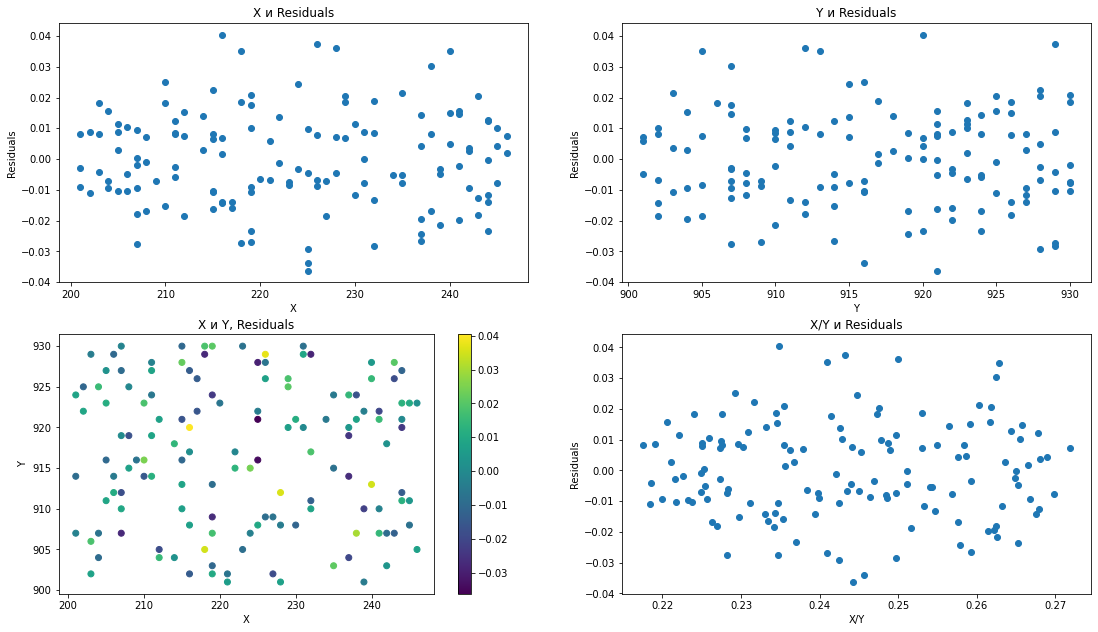

In [ ]:
# Диаграммы рассеяния
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(18.5, 10.5)

ax[0, 0].scatter(data['X'], y_res)
ax[0, 0].set_title('X и Residuals')
ax[0, 0].set_xlabel('X')
ax[0, 0].set_ylabel('Residuals')

ax[0, 1].scatter(data['Y'], y_res)
ax[0, 1].set_title('Y и Residuals')
ax[0, 1].set_xlabel('Y')
ax[0, 1].set_ylabel('Residuals')

XY = ax[1, 0].scatter(data['X'], data['Y'], c=y_res)
ax[1, 0].set_title('X и Y, Residuals')
ax[1, 0].set_xlabel('X')
ax[1, 0].set_ylabel('Y')
fig.colorbar(XY, ax=ax[1, 0])

ax[1, 1].scatter(data['X/Y'], y_res)
ax[1, 1].set_title('X/Y и Residuals')
ax[1, 1].set_xlabel('X/Y')
ax[1, 1].set_ylabel('Residuals')
plt.show()

In [ ]:
CBR_res = CatBoostRegressor(iterations=1000, 
                            depth=2, 
                            # learning_rate=0.1, 
                            loss_function='RMSE',
                            verbose=False, )

In [ ]:
cross_validate(CBR_res,
               np.concatenate([X[:, [0, 1, 2]], CBR.predict(X[:, [1, 2]]).reshape(-1, 1)], axis=1),
               y_res, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.027186578070268707

In [ ]:
def test(X, y, model, model_res, n=100):
    scores = []
    scores_res = []
    for i in range(n):
        print(i, end=' ')
        X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.01, random_state=i)
        model.fit(X_train_[:, [1, 2]], y_train_)
        y_train_pred_ = model.predict(X_train_[:, [1, 2]])
        y_res_ = y_train_ - y_train_pred_
        model_res.fit(np.concatenate([X_train_[:, [0, 1, 2]], y_train_pred_.reshape(-1, 1)], axis=1), y_res_)
        pred = model.predict(X_test_[:, [1, 2]]) + model_res.predict(np.concatenate([X_test_[:, [0, 1, 2]], model.predict(X_test_[:, [1, 2]]).reshape(-1, 1)], axis=1))
        scores.append(RMSE(y_test_, model.predict(X_test_[:, [1, 2]]), squared=False))
        scores_res.append(RMSE(y_test_, pred, squared=False))
    return scores, scores_res

In [ ]:
scores, scores_res = test(X, y, CBR, CBR_res, 100)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [ ]:
np.mean(scores), np.mean(scores_res)

(0.046641826754006584, 0.04679285640551185)

In [ ]:
np.std(scores)

0.027764161735994147

## Поищем параметры

In [ ]:
CBR = CatBoostRegressor(iterations=None, 
                        depth=None, 
                        # learning_rate=0.1, 
                        loss_function='RMSE',
                        verbose=False)

grid = {'learning_rate': [0.03, 0.1, 0.2, 0.5, 0.7],
        'l2_leaf_reg': [0.1, 0.5, 1, 2, 3, 4], 
        'depth': [2, 3, 4, 5]}

grid_search_result = CBR.grid_search(grid, 
                                     X=X[:, [1, 2]], 
                                     y=y, 
                                     plot=True,
                                     #train_size=0.8,
                                     # cv=3, 
                                     )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.05303255499
bestIteration = 200

0:	loss: 0.0530326	best: 0.0530326 (0)	total: 292ms	remaining: 34.7s

bestTest = 0.05262122378
bestIteration = 49

1:	loss: 0.0526212	best: 0.0526212 (1)	total: 444ms	remaining: 26.2s

bestTest = 0.0545284109
bestIteration = 28

2:	loss: 0.0545284	best: 0.0526212 (1)	total: 610ms	remaining: 23.8s

bestTest = 0.04958022272
bestIteration = 9

3:	loss: 0.0495802	best: 0.0495802 (3)	total: 744ms	remaining: 21.6s

bestTest = 0.05203729698
bestIteration = 7

4:	loss: 0.0520373	best: 0.0495802 (3)	total: 871ms	remaining: 20s

bestTest = 0.05387585432
bestIteration = 164

5:	loss: 0.0538759	best: 0.0495802 (3)	total: 1.02s	remaining: 19.4s

bestTest = 0.05283520539
bestIteration = 57

6:	loss: 0.0528352	best: 0.0495802 (3)	total: 1.14s	remaining: 18.4s

bestTest = 0.05215202759
bestIteration = 32

7:	loss: 0.0521520	best: 0.0495802 (3)	total: 1.27s	remaining: 17.8s

bestTest = 0.04873482291
bestIteration = 10

8:	loss: 0.0487348	best: 0.0487348 (8

CatBoostError: ignored

In [ ]:
grid_search_result['params']

{'depth': 2, 'l2_leaf_reg': 3, 'learning_rate': 0.2}

__Решение 2__

In [ ]:
CBR = CatBoostRegressor(iterations=1000, 
                        depth=3, 
                        # learning_rate=0.1,
                        l2_leaf_reg=1, 
                        loss_function='RMSE',
                        verbose=False)

In [ ]:
CBR.fit(X[:, [1, 2]], y)
pred = CBR.predict(X_unknown[:, [1, 2]])
unknown_data['NTG'] = pred
pred

array([0.25500366, 0.2515409 , 0.25867518, ..., 0.38833183, 0.38097761,
       0.40665674])

In [ ]:
# Сохранение 27 фев 2021, 21:04:59
unknown_data.drop('X/Y', axis=1).to_csv(strftime("%Y-%m-%d %H:%M:%S") + " prediction.csv", index=False)
strftime("%Y-%m-%d %H:%M:%S")

'2021-02-27 18:03:39'

In [ ]:
CBR = CatBoostRegressor(iterations=1500, 
                        depth=3, 
                        # learning_rate=0.1,
                        l2_leaf_reg=1, 
                        loss_function='RMSE',
                        verbose=False)
CBR.fit(X[:, [1, 2]], y)
pred = CBR.predict(X_unknown[:, [1, 2]])
print(pred)
unknown_data['NTG'] = pred
# Сохранение 27 фев 2021, 21:39:39
unknown_data.drop('X/Y', axis=1).to_csv(strftime("%Y-%m-%d %H:%M:%S") + " prediction.csv", index=False)
strftime("%Y-%m-%d %H:%M:%S")

'2021-02-27 18:39:00'

__Решение 2__

### Посмотрим, где модель больше ошибается

## Ядра

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

plf = PolynomialFeatures(degree=4, include_bias=False)
X_plf = plf.fit_transform(X[:, [0, 1]])

In [ ]:
cross_validate(CBR, X_plf, y, cv=138, scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.04695345659445255

In [ ]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor

rbf_feature = RBFSampler(gamma=1, n_components=10, random_state=1)
X_features = rbf_feature.fit_transform(X[:, [0, 1]])

cross_validate(SGDRegressor(loss='huber'),
               X_features, y, cv=46,
               scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.07233993212230157

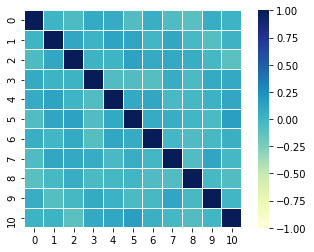

In [ ]:
sns.heatmap(np.corrcoef(X_features, y, rowvar=False), vmin = -1, vmax = 1, linewidths = 0.01, square = True, cmap="YlGnBu")
plt.show()

In [ ]:
cross_validate(CBR,
               X_features, y, cv=46,
               scoring='neg_root_mean_squared_error')['test_score'].mean()

-0.07876703557359423

## Стакинг

In [31]:
clf = StackingRegressor(estimators=[
                        ('cbr', CatBoostRegressor(iterations=1500, 
                        depth=3, 
                        # learning_rate=0.1,
                        l2_leaf_reg=1, 
                        loss_function='RMSE',
                        verbose=False)),
                        ('mlp_pipe', Pipeline(
    [('qt', QuantileTransformer(n_quantiles=100, output_distribution='normal', random_state=280221)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(256, 16), max_iter=5000, solver='lbfgs', activation='relu', alpha=0.01, random_state=0))]
))
], final_estimator=CatBoostRegressor(iterations=1500, 
                        depth=3, 
                        learning_rate=0.5,
                        l2_leaf_reg=1, 
                        loss_function='RMSE',
                        verbose=False), cv=46)

clf.fit(X_train[:, [1, 2]], y_train).score(X_test[:, [1, 2]], y_test)

0.5208500324877735

RMSE = 0.04437208686998476


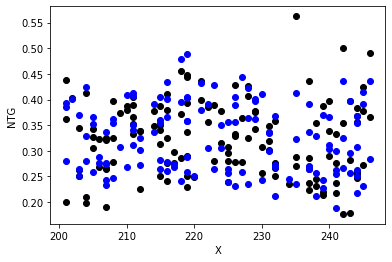

In [32]:
# RMSE на трейне
pred = clf.predict(X_train[:, [1, 2]])
print('RMSE =', RMSE(y_train, pred, squared=False))

plt.scatter(X_train[:, 0], y_train,  color='black')
plt.scatter(X_train[:, 0], pred, color='blue', linewidth=1)

plt.xlabel('X')
plt.ylabel('NTG')

plt.show()

RMSE = 0.039624770302691896


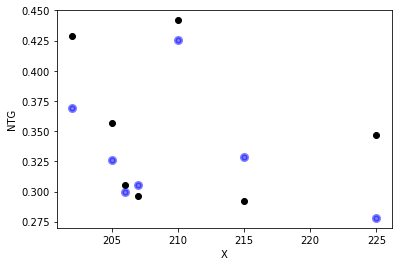

In [33]:
# RMSE на тесте
pred = clf.predict(X_test[:, [1, 2]])
print('RMSE =', RMSE(y_test, pred, squared=False))

plt.scatter(X_test[:, 0], y_test,  color='black')
plt.scatter(X_test[:, 0], pred, color='blue', linewidth=3, alpha=0.5)

plt.xlabel('X')
plt.ylabel('NTG')

plt.show()

In [35]:
%%time
clf = StackingRegressor(estimators=[
                        ('cbr', CatBoostRegressor(iterations=1500, 
                        depth=3, 
                        # learning_rate=0.1,
                        l2_leaf_reg=1, 
                        loss_function='RMSE',
                        verbose=False)),
                        ('mlp_pipe', Pipeline(
    [('qt', QuantileTransformer(n_quantiles=100, output_distribution='normal', random_state=280221)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(256, 16), max_iter=5000, solver='lbfgs', activation='relu', alpha=0.01, random_state=0))]
))
], final_estimator=CatBoostRegressor(iterations=1500, 
                        depth=3, 
                        learning_rate=0.5,
                        l2_leaf_reg=1, 
                        loss_function='RMSE',
                        verbose=False), cv=138, verbose=True)

clf.fit(X[:, [1, 2]], y)
print(clf.score(X[:, [1, 2]], y))

0.6374126963685327
CPU times: user 9min 34s, sys: 7min 13s, total: 16min 48s
Wall time: 10min 2s


RMSE = 0.04345663658513674


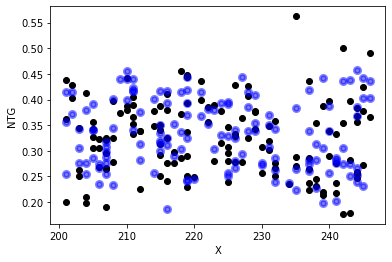

In [177]:
# RMSE на тесте
pred = clf.predict(X[:, [1, 2]])
print('RMSE =', RMSE(y, pred, squared=False))

plt.scatter(X[:, 0], y,  color='black')
plt.scatter(X[:, 0], pred, color='blue', linewidth=3, alpha=0.5)

plt.xlabel('X')
plt.ylabel('NTG')

plt.show()

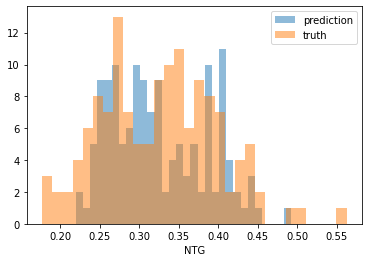

In [274]:
plt.hist(clf.predict(X[:, [1, 2]]), alpha=0.5, bins=30)
plt.hist(y, alpha=0.5, bins=30)
plt.legend(['prediction', 'truth'])
plt.xlabel('NTG')
plt.show()

__Решение 4__

In [38]:
pred = clf.predict(X_unknown[:, [1, 2]])
print(pred)
unknown_data['NTG'] = pred
# Сохранение 2 мрт 2021, 19:42:53
unknown_data.drop('X/Y', axis=1).to_csv(strftime("%Y-%m-%d %H:%M:%S") + " prediction.csv", index=False)
strftime("%Y-%m-%d %H:%M:%S")

[0.36510858 0.29205965 0.27095216 ... 0.4613425  0.44311981 0.43002696]


'2021-03-02 16:41:49'

__Решение 4__

In [272]:
%%time
clf = StackingRegressor(estimators=[
                        ('cbr', CatBoostRegressor(iterations=1500, 
                        depth=3, 
                        # learning_rate=0.1,
                        l2_leaf_reg=1, 
                        loss_function='RMSE',
                        verbose=False)),
                        ('mlp_pipe', TransformedTargetRegressor(
    regressor=Pipeline(
        [('qt', QuantileTransformer(n_quantiles=100, output_distribution='normal', random_state=280221)),
        ('mlp', MLPRegressor(hidden_layer_sizes=(256, 16), max_iter=5000, solver='lbfgs', activation='tanh', alpha=0.01, random_state=0))]
    ),
    transformer=MyTransformer()
))
], final_estimator=CatBoostRegressor(iterations=1500, 
                        depth=3, 
                        learning_rate=0.5,
                        l2_leaf_reg=1, 
                        loss_function='RMSE',
                        verbose=False), cv=138, verbose=True)

clf.fit(X[:, [1, 2]], y)
print(clf.score(X[:, [1, 2]], y))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:  2.3min finished
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-pac

0.5792400449367765
CPU times: user 19min 29s, sys: 14min 28s, total: 33min 58s
Wall time: 18min 41s


In [273]:
pred = clf.predict(X_unknown[:, [1, 2]])
print(pred)
unknown_data['NTG'] = pred
# Сохранение 2 мрт 2021, 23:49:25
unknown_data.drop('X/Y', axis=1).to_csv(strftime("%Y-%m-%d %H:%M:%S") + " prediction.csv", index=False)
strftime("%Y-%m-%d %H:%M:%S")

[0.21107892 0.27866481 0.26972163 ... 0.40624974 0.40575634 0.47161959]


'2021-03-02 20:48:14'